<a href="https://colab.research.google.com/github/lj89/Colab/blob/master/Feb_16_2_CapstoneB_Fixed%26Rolling_MultivariateLSTM_WB_Product2_12m_horizen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate time series - stacked LSTM model

## Data Prep

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

import pandas as pd
import numpy as np

from numpy import zeros, newaxis

In [3]:
# allow access to google drive files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
chain_dict = {"WESTERN BEV LIQ TX":"WB","SPEC S LIQUOR":"SPECS","THE BARREL HOUSE":"BARREL"}

# change to pull data for another product/customer
#chain = "SPEC S LIQUOR"
chain = "WESTERN BEV LIQ TX"
#chain = "THE BARREL HOUSE"
chain_abbr = chain_dict.get(chain)

#prod_name = "TAAKA VODKA 80 BLUE PET 375M"
prod_name = "MCCORMICK VODKA 80 PET 1L"


data_path = "/content/drive/My Drive/Colab Notebooks/Capstone/data/"
data_filename = data_path + chain_abbr + "_" + prod_name + ".csv"
print(data_filename)

/content/drive/My Drive/Colab Notebooks/Capstone/data/WB_MCCORMICK VODKA 80 PET 1L.csv


In [6]:
# import cleaned data
df_full = pd.read_csv(data_filename)
df_full = df_full[['STDCases','Index','Month_Num','Price']]
print(df_full.shape)
df_full.head()

(83, 4)


,STDCases,Index,Month_Num,Price
0,32.0,0,1,60.77
1,20.0,1,2,60.77
2,34.0,2,3,60.77
3,26.0,3,4,60.77
4,34.0,4,5,60.77


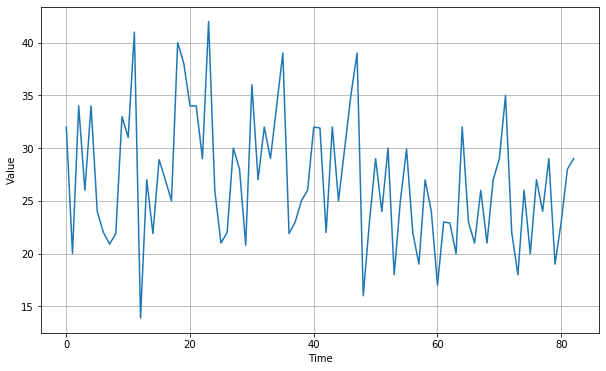

In [7]:
# plot time series
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
plt.figure(figsize=(10, 6))
plot_series(df_full['Index'], df_full['STDCases'])

(0, 65.8618181818182)

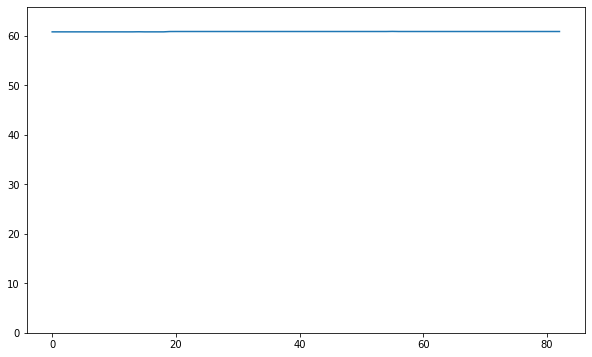

In [8]:
# decide whether to include price
plt.figure(figsize=(10, 6))
plt.plot(df_full['Price'])
plt.ylim(bottom=0,top=max(df_full.Price)+5)

In [0]:
include_price = False

In [0]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out, n_features=2): # MODIFIED: added num features
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out # MODIFIED: removed -1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :n_features], sequences[end_ix:out_end_ix, -1] # MODIFIED: removed -1 from end_ix-1
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [0]:
time = np.array(df_full['Index'])
month_num = np.array(df_full['Month_Num'])
price = np.array(df_full['Price'])
cases = np.array(df_full['STDCases'])

In [0]:
# define input sequence
in_seq1 = time
in_seq2 = month_num
in_seq3 = price
out_seq = cases # put target variable last

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
if include_price:
  dataset = hstack((in_seq1, in_seq2, in_seq3, out_seq))
else:
  dataset = hstack((in_seq1, in_seq2, out_seq))

In [13]:
print(dataset.shape)
dataset[0:13]

(83, 3)


array([[ 0. ,  1. , 32. ],
       [ 1. ,  2. , 20. ],
       [ 2. ,  3. , 34. ],
       [ 3. ,  4. , 26. ],
       [ 4. ,  5. , 34. ],
       [ 5. ,  6. , 24. ],
       [ 6. ,  7. , 22. ],
       [ 7. ,  8. , 20.9],
       [ 8. ,  9. , 21.9],
       [ 9. , 10. , 33. ],
       [10. , 11. , 31. ],
       [11. , 12. , 41. ],
       [12. ,  1. , 13.9]])

## Fixed Partition

#### Tune parameters

In [0]:
# choose a number of time steps
n_steps_in = 12 # like window size
n_steps_out = 12 # how far out to predict

# fixed partition predictions
n = dataset.shape[0]
#split_time = n - n_steps_out
split_time = int(n/2) # for parameter tuning

dataset_train = dataset[:split_time,]
dataset_test = dataset[split_time:]

time_valid = dataset_test[:,0] # time/index is first column
y_test = dataset_test[:,-1] # target is last column

In [15]:
print(dataset_train.shape)
print(dataset_test.shape)

(41, 3)
(42, 3)


NOTE: if including price, can use 3 or 4 features; if not, keep 2 or 3. The larger number includes the previous values of cases sold

In [16]:
# convert training set into input/output
# try with different n_features values
X, y = split_sequences(dataset_train, n_steps_in, n_steps_out, n_features=3)
print(X.shape)
print(y.shape)

X_validation, y_validation = split_sequences(dataset_test, n_steps_in, n_steps_out, n_features=3)

(18, 12, 3)
(18, 12)


In [17]:
# define model
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# the dataset knows the number of features
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
opt=tf.keras.optimizers.SGD(lr=2e-6  , momentum=0.9)
# opt = tf.keras.optimizers.Adam(learning_rate=0.000001)
#opt = 'adam'
model.compile(optimizer=opt, loss='mse', metrics=["mae"])

# fit model
history = model.fit(X, y, epochs=500, validation_data=(X_validation,y_validation))

Train on 18 samples, validate on 19 samples
Epoch 1/500
18/18 [==============================] - 3s 180ms/sample - loss: 873.6453 - mae: 28.7624 - val_loss: 572.7867 - val_mae: 22.8757
Epoch 2/500
18/18 [==============================] - 0s 3ms/sample - loss: 860.7059 - mae: 28.5281 - val_loss: 569.4749 - val_mae: 22.7428
Epoch 3/500
18/18 [==============================] - 0s 3ms/sample - loss: 837.7973 - mae: 28.0808 - val_loss: 563.3369 - val_mae: 22.5373
Epoch 4/500
18/18 [==============================] - 0s 3ms/sample - loss: 809.5667 - mae: 27.5314 - val_loss: 552.4260 - val_mae: 22.2261
Epoch 5/500
18/18 [==============================] - 0s 3ms/sample - loss: 772.0959 - mae: 26.7955 - val_loss: 532.3546 - val_mae: 21.6955
Epoch 6/500
18/18 [==============================] - 0s 3ms/sample - loss: 710.2673 - mae: 25.4793 - val_loss: 497.3142 - val_mae: 20.7792
Epoch 7/500
18/18 [==============================] - 0s 3ms/sample - loss: 632.4625 - mae: 23.7364 - val_loss: 448.9756 

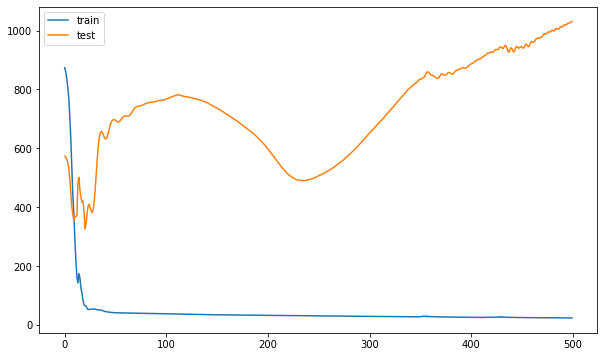

In [18]:
# plot history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
# decide model params
OPTIMIZER = opt
NUM_EPOCHS = 220
NUM_FEATURES = 3

#### Final fixed-partition model

In [0]:
# choose a number of time steps
n_steps_in = 12 # like window size
n_steps_out = 12 # how far out to predict

# fixed partition predictions
n = dataset.shape[0]
split_time = n - n_steps_out

dataset_train = dataset[:split_time,]
dataset_test = dataset[split_time:]

time_valid = dataset_test[:,0] # time/index is first column
y_test = dataset_test[:,-1] # target is last column

In [21]:
# convert training set into input/output
# try with different n_features values
X, y = split_sequences(dataset_train, n_steps_in, n_steps_out, n_features=NUM_FEATURES)
print(X.shape)
print(y.shape)

(48, 12, 3)
(48, 12)


In [22]:
# define model
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# the dataset knows the number of features
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))

model.compile(optimizer=OPTIMIZER, loss='mse', metrics=["mae"])

# fit model
history = model.fit(X, y, epochs=NUM_EPOCHS)

Train on 48 samples
Epoch 1/220
48/48 [==============================] - 1s 31ms/sample - loss: 759.1710 - mae: 26.6744
Epoch 2/220
48/48 [==============================] - 0s 1ms/sample - loss: 735.1257 - mae: 26.1953
Epoch 3/220
48/48 [==============================] - 0s 910us/sample - loss: 678.4293 - mae: 24.9659
Epoch 4/220
48/48 [==============================] - 0s 938us/sample - loss: 580.3781 - mae: 22.4223
Epoch 5/220
48/48 [==============================] - 0s 918us/sample - loss: 447.0414 - mae: 18.3692
Epoch 6/220
48/48 [==============================] - 0s 1ms/sample - loss: 313.7139 - mae: 14.4554
Epoch 7/220
48/48 [==============================] - 0s 1ms/sample - loss: 263.6146 - mae: 12.7592
Epoch 8/220
48/48 [==============================] - 0s 1ms/sample - loss: 183.8996 - mae: 10.8490
Epoch 9/220
48/48 [==============================] - 0s 996us/sample - loss: 150.5538 - mae: 9.8024
Epoch 10/220
48/48 [==============================] - 0s 1ms/sample - loss: 85.24

#### Multi-step forecasts (no knowledge of test data)

In [23]:
# make predictions
x_input = dataset_train[len(dataset_train)-n_steps_in:,:n_features]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input)
print(len(yhat[0])) # should be n_steps_out (i.e. horizon)
print(yhat[0])
print(y_test)

12
[14.950469 18.901737 18.837313 16.269007 26.484924 27.14271  19.5769
 19.781368 18.646515 22.863049 23.83155  26.04471 ]
[35. 22. 18. 26. 20. 27. 24. 29. 19. 23. 28. 29.]


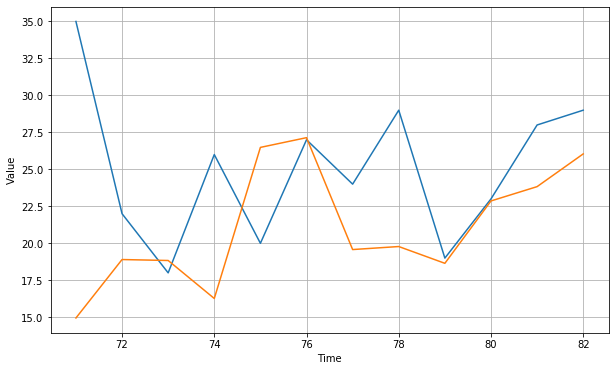

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, y_test)
plot_series(time_valid, yhat[0])

In [25]:
mae = tf.keras.metrics.mean_absolute_error(y_test, yhat[0]).numpy()
mae

5.133303

## Rolling Window

In [26]:
# forecasts with rolling window
# need to run separately for different horizons

n = dataset.shape[0]

train_size = 24
n_steps_in = 12 # like window size
n_steps_out = 12 # horizon

num_windows = n - train_size - n_steps_out + 1
print(num_windows)

48


In [0]:
mae_list = []
start_index_list = range(num_windows)

In [0]:
#start_index_list = range(5) # for testing

In [29]:
# loop through windows

for start_index in start_index_list:
    split_time = start_index + train_size 

    dat_train = dataset[start_index:split_time]
    dat_test = dataset[split_time:split_time + n_steps_out]
    y_test = dat_test[:,-1]

    # convert training data to samples
    X, y = split_sequences(dat_train, n_steps_in, n_steps_out, n_features=NUM_FEATURES) # num_features could be 2 or 3

    # setup model
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    n_features = X.shape[2]
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer=OPTIMIZER, loss='mse', metrics=["mae"])

    # fit model
    model.fit(X, y, epochs=NUM_EPOCHS, verbose=0)

    # make forecasts on test set
    x_test_input = dat_train[len(dat_train)-n_steps_in:,:n_features]
    x_test_input = x_test_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_test_input)

    mae_multiv = tf.keras.metrics.mean_absolute_error(y_test, yhat[0]).numpy()
    mae_list.append(mae_multiv)
    print("horizon " + str(n_steps_out) + " MAE: " + str(mae_multiv))
    
    print(start_index)

horizon 12 MAE: 5.8221073
0
horizon 12 MAE: 3.942517
1
horizon 12 MAE: 9.640397
2
horizon 12 MAE: 6.5216427
3
horizon 12 MAE: 5.3832755
4
horizon 12 MAE: 8.74791
5
horizon 12 MAE: 11.577947
6
horizon 12 MAE: 14.302052
7
horizon 12 MAE: 8.173095
8
horizon 12 MAE: 9.582173
9
horizon 12 MAE: 5.9180965
10
horizon 12 MAE: 8.666715
11
horizon 12 MAE: 14.22058
12
horizon 12 MAE: 5.2514615
13
horizon 12 MAE: 5.3119965
14
horizon 12 MAE: 8.061317
15
horizon 12 MAE: 6.621696
16
horizon 12 MAE: 6.170693
17
horizon 12 MAE: 5.6475434
18
horizon 12 MAE: 5.6971016
19
horizon 12 MAE: 7.977568
20
horizon 12 MAE: 4.4513416
21
horizon 12 MAE: 9.090643
22
horizon 12 MAE: 9.915266
23
horizon 12 MAE: 16.561617
24
horizon 12 MAE: 11.26649
25
horizon 12 MAE: 10.469206
26
horizon 12 MAE: 13.133023
27
horizon 12 MAE: 15.523513
28
horizon 12 MAE: 9.601102
29
horizon 12 MAE: 17.57107
30
horizon 12 MAE: 8.3146
31
horizon 12 MAE: 8.281979
32
horizon 12 MAE: 8.855549
33
horizon 12 MAE: 5.2550263
34
horizon 12 MAE: 6

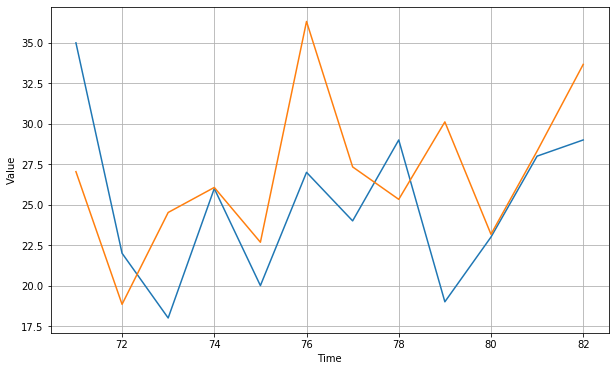

In [30]:
# show last set of forecasts
plt.figure(figsize=(10, 6))
time_valid = dat_test[:,0]
plot_series(time_valid, y_test)
plot_series(time_valid, yhat[0])

In [0]:
def mean(lst): 
    return sum(lst) / len(lst) 

In [32]:
average_mae = mean(mae_list)
average_mae

8.143090551098188